In [13]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import rosbag
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
from IPython.display import display
from mpldatacursor import datacursor
import time
import math
import sys

In [14]:
#LOAD DATA

filename='2018-11-21-Alumnai-1'

encoder_df=pd.read_csv('./csv_data/' + filename + '-encoder.csv',converters={'encoder_time': Decimal})
imu_df=pd.read_csv('./csv_data/' + filename + '-imu.csv',converters={'imureal_time': Decimal})
wifi_df=pd.read_csv('./csv_data/'+filename + '-wifi.csv',converters={'wifi_time': Decimal})

In [15]:
#BRING DATA TO ENCODER TIME

imu_df['imureal_time']=imu_df['imureal_time']-encoder_df['encoder_time'][0]
wifi_df['wifi_time']=wifi_df['wifi_time']-encoder_df['encoder_time'][0]


encoder_df['encoder_time']=encoder_df['encoder_time']-encoder_df['encoder_time'][0]


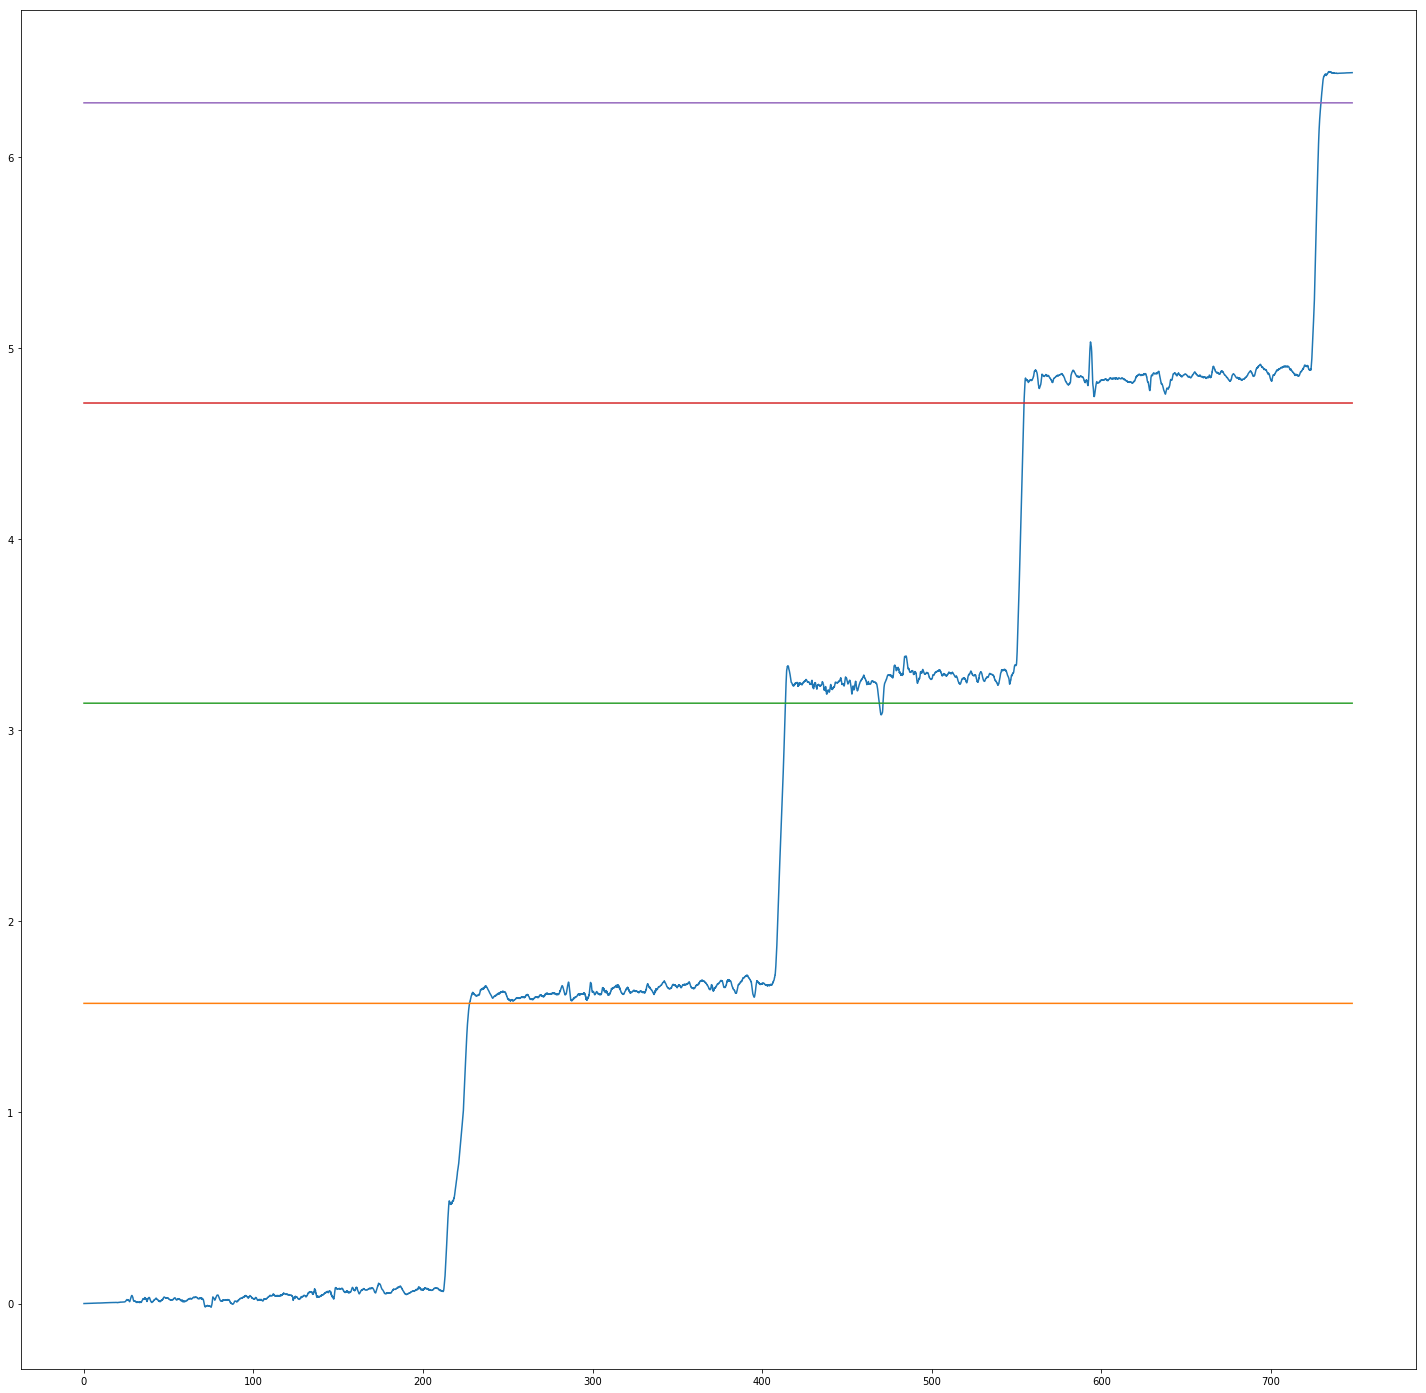

In [16]:
#INTEGRATE IMU DATA

imu_df['imureal_angvZ']=imu_df['imureal_angvZ']-imu_df['imureal_angvZ'][0]

#plt.figure(1)
#plt.plot(imu_df['imureal_time'],imu_df['imureal_angvZ'])

angvZ=np.array(imu_df['imureal_angvZ'])
imu_time_float=np.array(np.float64(imu_df['imureal_time']))

theta_cum=integrate.cumtrapz(angvZ,imu_time_float,initial=0)
imu_df['theta']=theta_cum  

plt.figure(1)
plt.plot(imu_df['imureal_time'],theta_cum)
plt.plot(imu_df['imureal_time'],np.ones([imu_time_float.shape[0]])*1*(np.pi)/2)
plt.plot(imu_df['imureal_time'],np.ones([imu_time_float.shape[0]])*2*(np.pi)/2)
plt.plot(imu_df['imureal_time'],np.ones([imu_time_float.shape[0]])*3*(np.pi)/2)
plt.plot(imu_df['imureal_time'],np.ones([imu_time_float.shape[0]])*4*(np.pi)/2)
i=0
fact=1


#angv=np.array([])
#theta=np.array([])

#for anglevals in theta_cum:
    
#    if anglevals <= (fact*(np.pi)/2):

#        angv=np.append(angv,angvZ[i])
        
#    else:
#        angle_cum=integrate.cumtrapz(angv,imu_time_float[(i-angv.shape[0]):i],initial=0)
#        theta=np.append(theta,angle_cum)
#        angv=np.array([])
#        fact=fact+1


#    i=i+1
    

In [17]:
#LOAD TO ARRAYS

mean_enc=np.array(encoder_df['encoder_mean'])
enc_time=np.array(encoder_df['encoder_time'])
imu_time=np.array(imu_df['imureal_time'])
fin_theta=np.array(imu_df['theta'])
wifi_time=np.array(wifi_df['wifi_time'])
wifi_scans=np.array(wifi_df['wifi_data'])


In [18]:
start = time.time()

dist=0
i=0

encXcalib=6.608284615932709e-05;
encYcalib=6.603486193757895e-05;
mean_calib=np.mean([encXcalib,encYcalib])

enc_dist=np.array([])
angles=np.array([])
mean_theta=np.array([])
mean_enctime=np.array([])
end_enctime=np.array([])

encsize=mean_enc.size

search_start=0
enciter=1

for timevals in imu_time:
        
    if enciter < encsize:
    
        if timevals <= enc_time[enciter]:

            angles=np.append(angles,fin_theta[i])

        else:

            dist=(mean_enc[enciter]-mean_enc[(enciter-1)])*mean_calib
            
            enc_dist=np.append(enc_dist,dist)
            
            mean_enctime=np.append(mean_enctime,((enc_time[enciter]+enc_time[enciter-1])/2))
            
            end_enctime=np.append(end_enctime,enc_time[enciter])

            mean_angle=angles.mean()
    

            if math.isnan(mean_angle):
                mean_theta=np.append(mean_theta,mean_theta[enciter-2])
            else:       
                mean_theta=np.append(mean_theta,mean_angle)

            enciter=enciter+1
            angles=np.array([])
    
    i=i+1    
    
end = time.time()
print 'Completed in: ',end-start   

Completed in:  0.726933002472


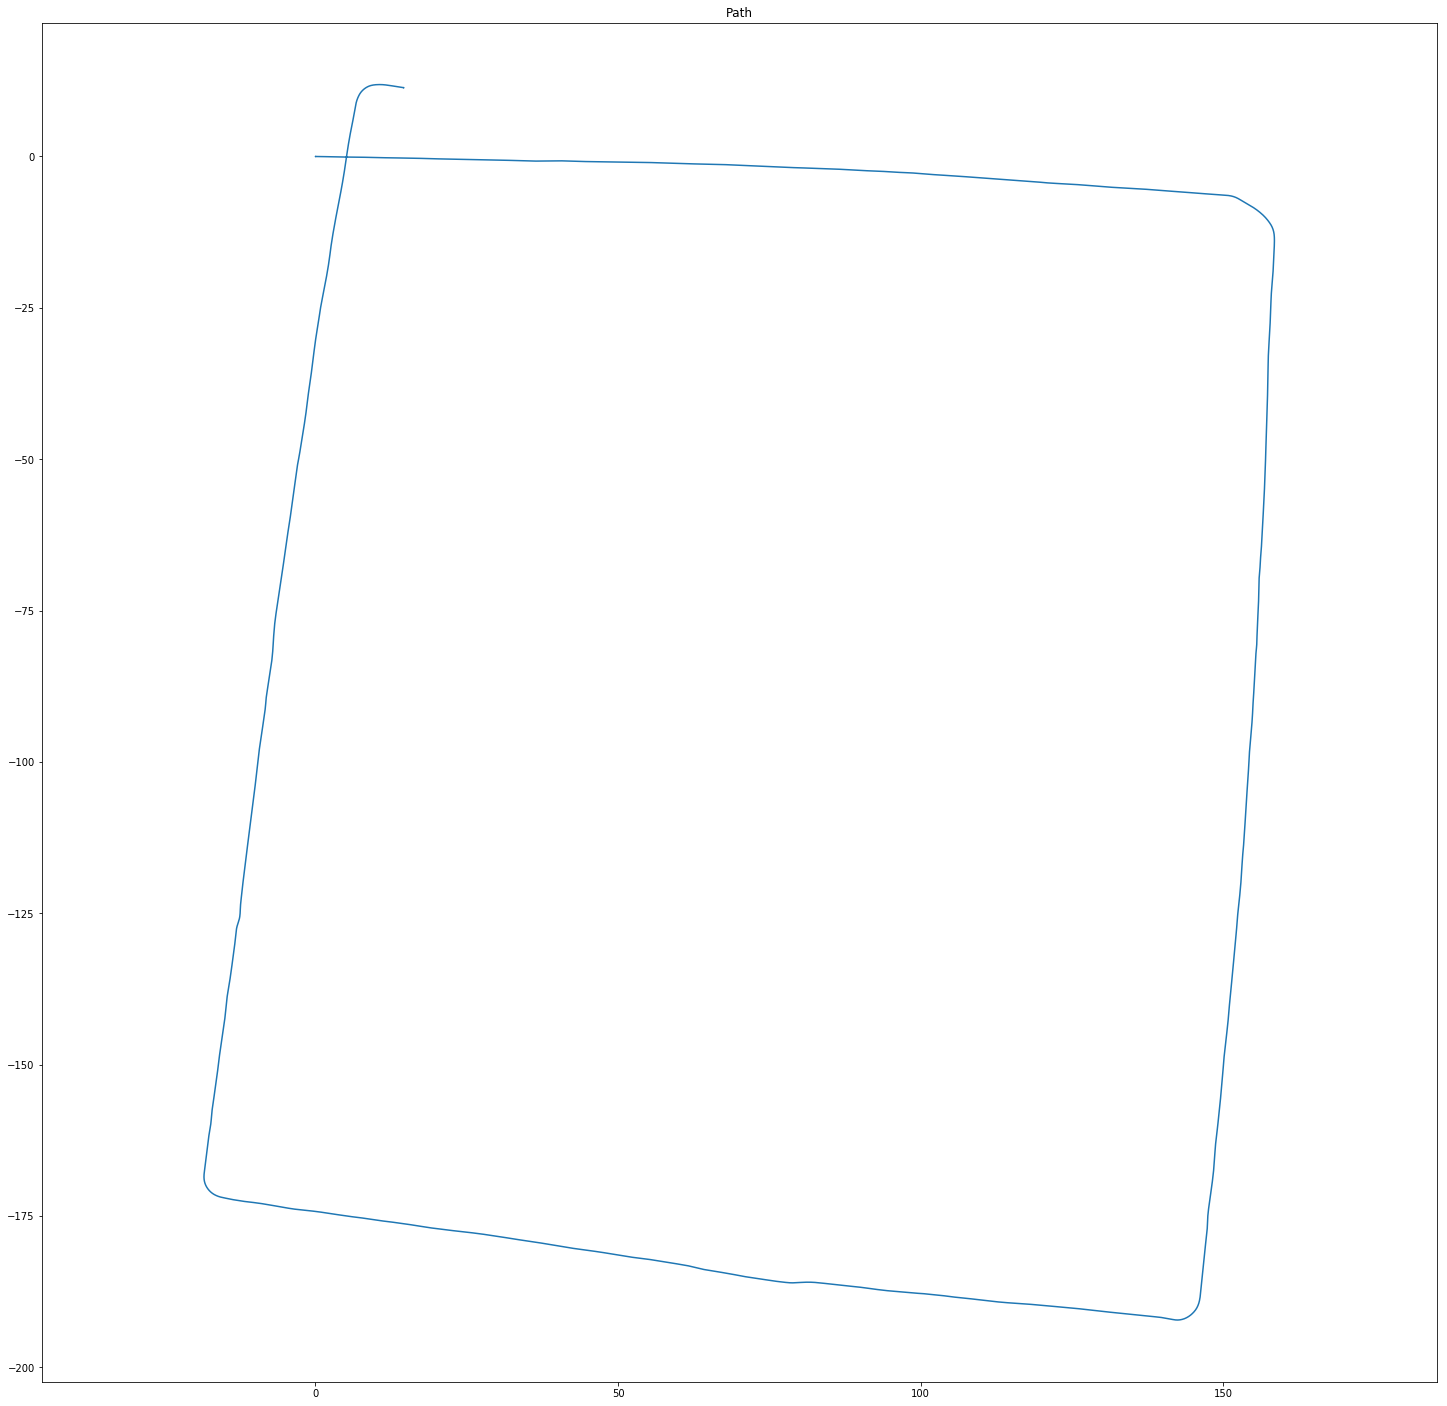

18.5185648598


In [19]:
#mean_theta=mean_theta-mean_theta[0]
#plt.rcParams['figure.figsize'] = [50,50]

dx=np.multiply(enc_dist,np.cos(-mean_theta))
dy=np.multiply(enc_dist,np.sin(-mean_theta))
Xd=0
Yd=0

X_pos=np.array([])
Y_pos=np.array([])


for num in range(0,encsize-1):
    
    Xd=Xd+dx[num]
    Yd=Yd+dy[num]
    
    X_pos=np.append(X_pos,Xd)
    Y_pos=np.append(Y_pos,Yd)

    

plt.plot(X_pos,Y_pos)
plt.axis('equal')
plt.title('Path')
datacursor()
plt.show()

error=np.sqrt((X_pos[-1] -X_pos[0])**2 + (Y_pos[-1] -Y_pos[0])**2)
print error

In [20]:
accdist=0
cellsize=5
cellnum=0
distiter=0
total_dist=0

celltime=np.array([])
celldists=np.array([])
cellindex=np.array([])

for dist in enc_dist:
    
    accdist=accdist+dist
    
    if accdist >= cellsize:
        cellnum=cellnum+1
        celltime=np.append(celltime,end_enctime[distiter])
        celldists=np.append(celldists,accdist)
        cellindex=np.append(cellindex,distiter)
        accdist=0
        
    total_dist=total_dist+dist
    distiter=distiter+1
    
    
    
    

In [21]:
celliter=0
i=0
scan_count=1
scan=''

for timevals in wifi_time:

    if celliter < celltime.size:
        
        if timevals <= celltime[celliter]:
            scandata='Scan'+str(scan_count)+';'+ str(wifi_scans[i]) + ';\n\n'
            scan=scan+scandata
            scan_count=scan_count+1 
    
        else:
            with open("scan" + str(celliter+1) + ".txt", "w") as text_file:
                text_file.write(scan)
            #print scan_count
            scan=''
            scan_count=1
            celliter=celliter+1
            
        
    i=i+1
    

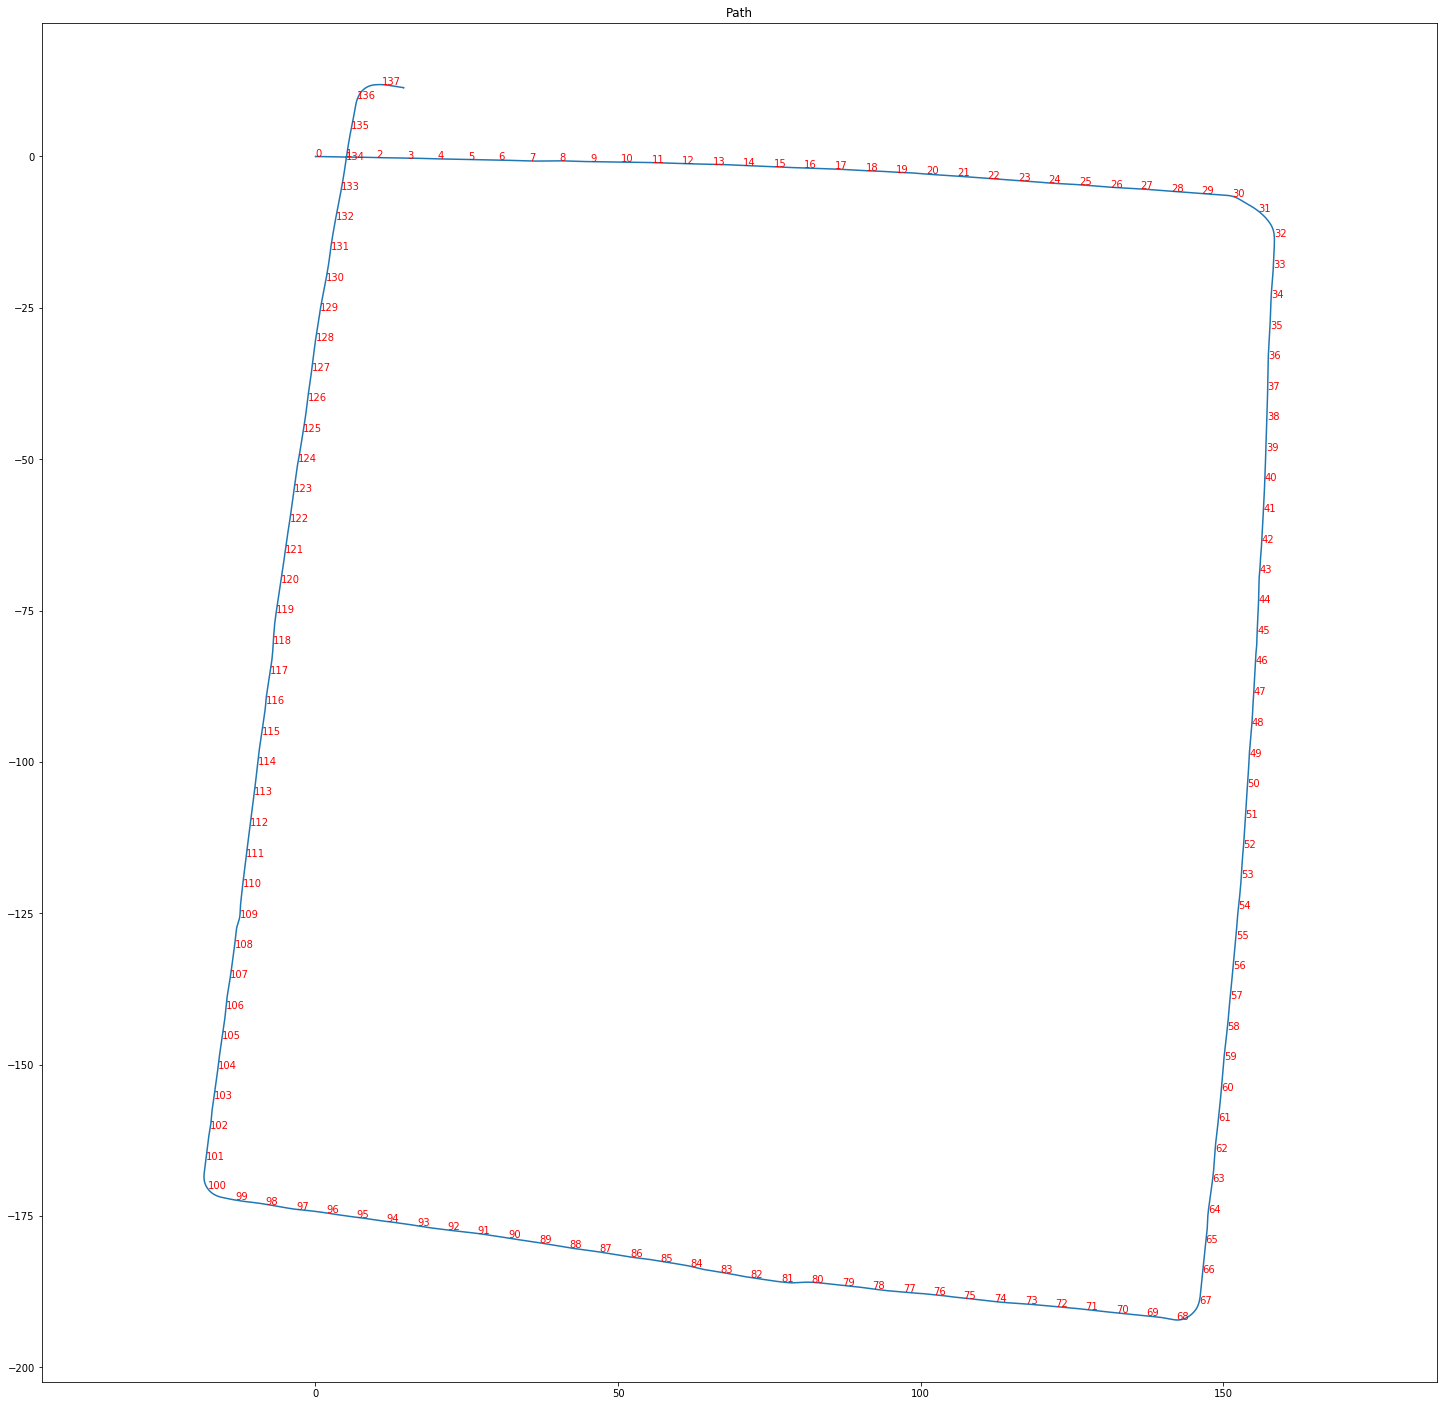

In [22]:
plt.rcParams['figure.figsize'] = [25,25]

plt.plot(X_pos,Y_pos)
plt.axis('equal')
plt.title('Path')
i=0

for vals in cellindex:
   
    plt.text(X_pos[np.int(vals)], Y_pos[np.int(vals)], str(i+1), color='red')
    
    i=i+1

plt.text(X_pos[0], Y_pos[(0)], str(0),color='red')

datacursor()
plt.show()

In [24]:
total_dist

696.14511502923312